In [5]:
import pandas as pd
import sqlalchemy
import numpy as np
from numpy import mean
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


import xgboost as xgb 
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
                             AdaBoostClassifier, GradientBoostingClassifier,\
                             GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor

In [6]:
def postgres_connector(host, port, database, user, password=None):
    user_info = user if password is None else user + ':' + password
    url = 'postgres://%s@%s:%d/%s' % (user_info, host, port, database)
    return sqlalchemy.create_engine(url, client_encoding='utf-8')

In [7]:
def read_data(table):
    query='select * from {}'.format(table)
    df=pd.read_sql(query, engine)
    return df

In [8]:
def little_merge(post_table, t2, table_name):
    
    #merge tables
    df_merge=post_table.merge(t2, on='post_key',how='left')
    
    #fill missing value
    df_merge['created_at_hour_y']=df_merge['created_at_hour_y'].fillna(df_merge['created_at_hour_x'])
    df_merge['count']=df_merge['count'].fillna(0)
    
    #exclude data which is not in training domain(10 hr)
    df_merge=df_merge[(df_merge['created_at_hour_y']-\
                       df_merge['created_at_hour_x']).dt.total_seconds()/3600<10]
    df_merge=df_merge[(df_merge['created_at_hour_y']-\
                      df_merge['created_at_hour_x']).dt.total_seconds()/3600>=0]
    df_merge['time_after_create']=(df_merge['created_at_hour_y']\
                                  -df_merge['created_at_hour_x']).dt.total_seconds()/3600
    
    #drop non-training columns
    df=df_merge.drop(['created_at_hour_x','created_at_hour_y', 'like_count_36_hour'], axis=1)
    
    #features engineering:generate new training features
    df_train=pd.pivot_table(df,values='count',index='post_key',columns='time_after_create')
    df_train=df_train.fillna(0)
    
    #rename the columns
    for i in range(10):
        df_train=df_train.rename(columns={df_train.columns[i]:'{} hour after {}'.format(i,table_name)})
    
    #convert float to int
    #df_train[list(df_train.columns)]=df_train[list(df_train.columns)].astype(int)
    
    return df_train

In [9]:
def post_table_feature_engineer(table):
    
    #adding new training categorical features: created_weekday, created_hour
    table['created_weekday']=table['created_at_hour'].apply(lambda x: x.weekday())
    table['created_time']=table['created_at_hour'].apply(lambda x: x.hour)
    
    #setting is_trending label where 'like_count_36_hour'>1000 => 1 and 'like_count_36_hour'<=1000 =>0
    table['is_trending']=table['like_count_36_hour'].apply(lambda x: 1 if x>1000 else 0)
    
    #drop non_training features
    table=table.drop(['created_at_hour','like_count_36_hour'], axis=1)
    
    return table

In [10]:
def big_merge(t1, t2, t3, t4, post_table):
    
    #outer join the 4 small tables
    df1=t1.merge(t2, on='post_key',how='outer')
    df2=df1.merge(t3, on='post_key',how='outer')
    df3=df2.merge(t4, on='post_key',how='outer')
    
    #left join post_table
    df=post_table.merge(df3, on='post_key',how='left')
    
    #fill missing values
    df=df.fillna(0)
    
    #convert float to int
    df[list(df.columns[1:])]=df[list(df.columns[1:])].astype(int)
    
    return df


In [11]:
def create_dummy(data, dummy_features):
    df=pd.get_dummies(data,columns=dummy_features, drop_first=True)

    return df

In [12]:
def train_test(train, test):
    x_train=train.iloc[:,2:]
    y_train=train['is_trending']
    x_test=test.iloc[:,2:]
    y_test=test['is_trending']
    
    return x_train, y_train, x_test, y_test

In [17]:
engine = postgres_connector(
"35.187.144.113",
5432,
"intern_task",
"candidate",
"dcard-data-intern-2020"
)

# Training data

In [473]:
df_posts=read_data('posts_train')
df_share=read_data('post_shared_train')
df_comment=read_data('post_comment_created_train')
df_like=read_data('post_liked_train')
df_collect=read_data('post_collected_train')

In [474]:
posts_share=little_merge(df_posts,df_share, 'share')
posts_comment=little_merge(df_posts,df_comment, 'comment')
posts_like=little_merge(df_posts,df_like, 'like')
posts_collect=little_merge(df_posts,df_collect, 'collect')

print(posts_share.head())
print(posts_comment.head())
print(posts_like.head())
print(posts_collect.head())

time_after_create                     0 hour after share  1 hour after share  \
post_key                                                                       
000019f8-5af9-41b7-919e-1f367c9da7e6                 0.0                 0.0   
00001b1c-4cb1-47f4-910c-8e724e9125cc                 0.0                 0.0   
000026a3-f20c-4c61-b754-1173b2b55ec6                 0.0                 0.0   
00002884-600a-45d0-9e81-3bed45fb4baa                 0.0                 0.0   
000055a4-3db3-4355-9d69-17617e5f8ff6                 0.0                 0.0   

time_after_create                     2 hour after share  3 hour after share  \
post_key                                                                       
000019f8-5af9-41b7-919e-1f367c9da7e6                 0.0                 0.0   
00001b1c-4cb1-47f4-910c-8e724e9125cc                 0.0                 0.0   
000026a3-f20c-4c61-b754-1173b2b55ec6                 0.0                 0.0   
00002884-600a-45d0-9e81-3bed45fb4baa   

In [475]:
df_posts_train=post_table_feature_engineer(df_posts)
df_posts_train.head()

,post_key,created_weekday,created_time,is_trending
0,0002f1f8-c96b-4332-8d19-9cdfa9900f75,5,5,0
1,000c74b1-533d-4445-94ab-038ed4b9a28d,4,15,0
2,000d9763-e88c-408e-907c-02db7656bb1f,0,19,0
3,000ffc2c-cc94-410a-9125-e98d1a21d2e2,1,15,0
4,001472bc-cd2e-4366-8db7-6a11bc3baf10,1,14,0


In [476]:
df=big_merge(posts_share, posts_comment, posts_like, posts_collect, df_posts_train)
print(df.shape)
df.head()

(793751, 44)


,post_key,created_weekday,created_time,is_trending,0 hour after share,1 hour after share,2 hour after share,3 hour after share,4 hour after share,5 hour after share,6 hour after share,7 hour after share,8 hour after share,9 hour after share,0 hour after comment,1 hour after comment,2 hour after comment,3 hour after comment,4 hour after comment,5 hour after comment,6 hour after comment,7 hour after comment,8 hour after comment,9 hour after comment,0 hour after like,1 hour after like,2 hour after like,3 hour after like,4 hour after like,5 hour after like,6 hour after like,7 hour after like,8 hour after like,9 hour after like,0 hour after collect,1 hour after collect,2 hour after collect,3 hour after collect,4 hour after collect,5 hour after collect,6 hour after collect,7 hour after collect,8 hour after collect,9 hour after collect
0,0002f1f8-c96b-4332-8d19-9cdfa9900f75,5,5,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,3,5,6,5,3,3,1,2,2,0,0,3,1,0,0,0,0,0,0
1,000c74b1-533d-4445-94ab-038ed4b9a28d,4,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000d9763-e88c-408e-907c-02db7656bb1f,0,19,0,0,0,0,0,0,0,1,0,0,0,7,5,6,0,4,2,1,4,7,2,3,3,5,1,2,4,1,4,1,4,2,0,2,0,1,2,0,2,0,0
3,000ffc2c-cc94-410a-9125-e98d1a21d2e2,1,15,0,0,0,0,0,0,0,0,0,0,0,2,4,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,001472bc-cd2e-4366-8db7-6a11bc3baf10,1,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [477]:
df_train=create_dummy(df, ['created_weekday', 'created_time'])
print(df_train.shape)
df_train.head()

(793751, 71)


,post_key,is_trending,0 hour after share,1 hour after share,2 hour after share,3 hour after share,4 hour after share,5 hour after share,6 hour after share,7 hour after share,8 hour after share,9 hour after share,0 hour after comment,1 hour after comment,2 hour after comment,3 hour after comment,4 hour after comment,5 hour after comment,6 hour after comment,7 hour after comment,8 hour after comment,9 hour after comment,0 hour after like,1 hour after like,2 hour after like,3 hour after like,4 hour after like,5 hour after like,6 hour after like,7 hour after like,8 hour after like,9 hour after like,0 hour after collect,1 hour after collect,2 hour after collect,3 hour after collect,4 hour after collect,5 hour after collect,6 hour after collect,7 hour after collect,8 hour after collect,9 hour after collect,created_weekday_1,created_weekday_2,created_weekday_3,created_weekday_4,created_weekday_5,created_weekday_6,created_time_1,created_time_2,created_time_3,created_time_4,created_time_5,created_time_6,created_time_7,created_time_8,created_time_9,created_time_10,created_time_11,created_time_12,created_time_13,created_time_14,created_time_15,created_time_16,created_time_17,created_time_18,created_time_19,created_time_20,created_time_21,created_time_22,created_time_23
0,0002f1f8-c96b-4332-8d19-9cdfa9900f75,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,3,5,6,5,3,3,1,2,2,0,0,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,000c74b1-533d-4445-94ab-038ed4b9a28d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,3,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,000d9763-e88c-408e-907c-02db7656bb1f,0,0,0,0,0,0,0,1,0,0,0,7,5,6,0,4,2,1,4,7,2,3,3,5,1,2,4,1,4,1,4,2,0,2,0,1,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,000ffc2c-cc94-410a-9125-e98d1a21d2e2,0,0,0,0,0,0,0,0,0,0,0,2,4,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,001472bc-cd2e-4366-8db7-6a11bc3baf10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# Testing data

In [18]:
df_posts_test=read_data('posts_test')
df_share_test=read_data('post_shared_test')
df_comment_test=read_data('post_comment_created_test')
df_like_test=read_data('post_liked_test')
df_collect_test=read_data('post_collected_test')

In [19]:
posts_share_test=little_merge(df_posts_test,df_share_test, 'share')
posts_comment_test=little_merge(df_posts_test,df_comment_test, 'comment')
posts_like_test=little_merge(df_posts_test,df_like_test, 'like')
posts_collect_test=little_merge(df_posts_test,df_collect_test, 'collect')

In [20]:
df_posts_test=post_table_feature_engineer(df_posts_test)
df_posts_test.head()

,post_key,created_weekday,created_time,is_trending
0,00017cc1-df93-4ce1-be7b-0b3c76cb3dc6,1,9,0
1,00021bc3-7699-4c97-9ec5-20edaac60cc1,4,14,0
2,000295a1-63ed-4081-b55a-a9b7648eaa7c,0,6,0
3,0005d1a6-d21e-4f4b-b753-d0cf5992e136,4,10,0
4,00062d15-4ee0-4a6c-a5f5-44113dc3fb41,0,2,0


In [21]:
df_t=big_merge(posts_share_test, posts_comment_test, posts_like_test, posts_collect_test, df_posts_test)
print(df_t.shape)
df_t.head()

(225986, 44)


,post_key,created_weekday,created_time,is_trending,0 hour after share,1 hour after share,2 hour after share,3 hour after share,4 hour after share,5 hour after share,...,0 hour after collect,1 hour after collect,2 hour after collect,3 hour after collect,4 hour after collect,5 hour after collect,6 hour after collect,7 hour after collect,8 hour after collect,9 hour after collect
0,00017cc1-df93-4ce1-be7b-0b3c76cb3dc6,1,9,0,1,0,0,0,0,0,...,4,0,0,0,2,0,0,0,0,0
1,00021bc3-7699-4c97-9ec5-20edaac60cc1,4,14,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,000295a1-63ed-4081-b55a-a9b7648eaa7c,0,6,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0005d1a6-d21e-4f4b-b753-d0cf5992e136,4,10,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,00062d15-4ee0-4a6c-a5f5-44113dc3fb41,0,2,0,0,0,0,0,0,0,...,0,1,1,0,0,2,1,0,1,3


In [22]:
df_test=create_dummy(df_t, ['created_weekday', 'created_time'])
print(df_test.shape)
df_test.head()

(225986, 71)


,post_key,is_trending,0 hour after share,1 hour after share,2 hour after share,3 hour after share,4 hour after share,5 hour after share,6 hour after share,7 hour after share,...,created_time_14,created_time_15,created_time_16,created_time_17,created_time_18,created_time_19,created_time_20,created_time_21,created_time_22,created_time_23
0,00017cc1-df93-4ce1-be7b-0b3c76cb3dc6,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00021bc3-7699-4c97-9ec5-20edaac60cc1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,000295a1-63ed-4081-b55a-a9b7648eaa7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0005d1a6-d21e-4f4b-b753-d0cf5992e136,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00062d15-4ee0-4a6c-a5f5-44113dc3fb41,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [483]:
x_train=df_train.iloc[:,2:]
y_train=df_train['is_trending']
x_test=df_test.iloc[:,2:]
y_test=df_test['is_trending']

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(793751, 69)
(225986, 69)
(793751,)
(225986,)


In [23]:
x_test=df_test.iloc[:,2:]
y_test=df_test['is_trending']

In [496]:
lr_clf = LogisticRegression(random_state=0)
sgd_clf = SGDClassifier(random_state=0)

# Ensemble models.
dt_clf = DecisionTreeClassifier(random_state=0)
bag_dt_base_learner = DecisionTreeClassifier(random_state=0)
bag_dt_clf = BaggingClassifier(base_estimator=bag_dt_base_learner,
                                 random_state=0)
rf_clf = RandomForestClassifier()

# Boosting models.
ada_boost_base_learner = DecisionTreeClassifier(random_state=0)
ada_boost_clf = AdaBoostClassifier(base_estimator=ada_boost_base_learner,
                                     random_state=0)
gb_clf = GradientBoostingClassifier(random_state=0)
xgb_clf = xgb.XGBClassifier(random_state=0)
lgb_clf = lgb.LGBMClassifier(objective='binary',
                               random_state=0)

In [497]:
clfs = [lr_clf,sgd_clf,
        dt_clf,bag_dt_clf,rf_clf,
        ada_boost_clf,gb_clf,xgb_clf, lgb_clf]
train_f1=[]
test_f1=[]
for i in clfs:
    i.fit(x_train, y_train)
    y_predict_x=i.predict(x_train)
    y_predict=i.predict(x_test)
    f1_train=f1_score(y_train, y_predict_x)
    f1_test=f1_score(y_test, y_predict)
    train_f1.append(f1_train)
    test_f1.append(f1_test)

/Users/hankchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hankchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [498]:
classifier= ['lr','sgd','dt','bag_dt','rf','ada_boost','gb','xgb', 'lgb']

In [499]:
df_f1 = pd.DataFrame({'classifier': classifier, 'training f1 score': train_f1, 'testing f1 score': test_f1})
df_f1

,classifier,training f1 score,testing f1 score
0,lr,0.579683,0.537050
1,sgd,0.575578,0.524633
2,dt,1.000000,0.492231
3,bag_dt,0.960221,0.571026
4,rf,0.958383,0.547350
5,ada_boost,1.000000,0.494311
6,gb,0.619188,0.573164
7,xgb,0.602755,0.567143
8,lgb,0.671511,0.626503


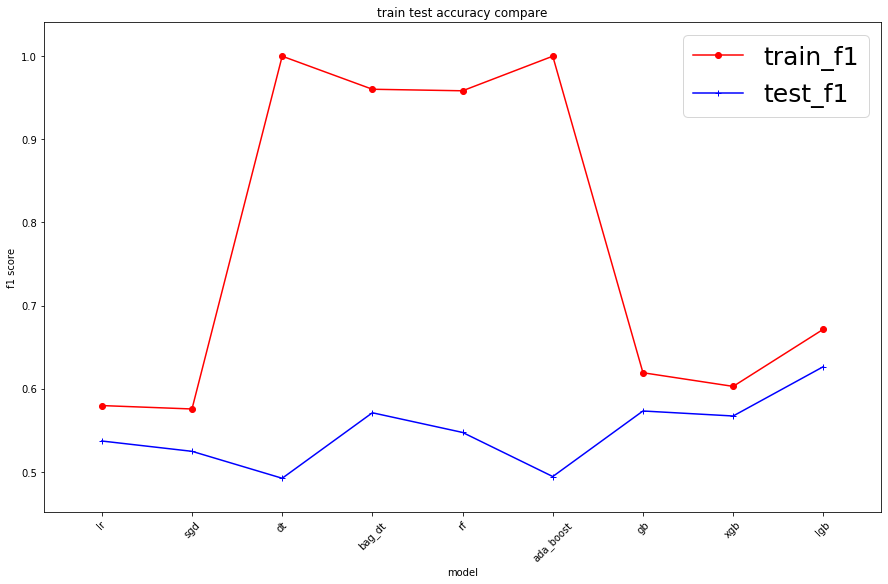

In [500]:
plt.figure(figsize=(15,10))
x = range(len(classifier))
plt.plot(x, train_f1,'ro-', label='train_f1')
plt.plot(x, test_f1, 'b+-', label='test_f1')

plt.xticks(x, classifier, rotation=45)
plt.margins(0.08)
plt.subplots_adjust(bottom=0.2)

plt.legend(loc='upper right', prop={'size': 25})
plt.xlabel('model')
plt.ylabel('f1 score')
plt.title('train test accuracy compare')

plt.show()

In [516]:
# Record the randomized grid searching time
start_time = time.time()

# Initiate the Logistic Regression Classifier
LGB_clf = lgb.LGBMClassifier(objective='binary',n_estimators=150,max_depth=-1 ,random_state=0)

# Construct ranges for each parameter 
param_grid ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

# Do the randomized grid searching 30 times 
# Find the optimal combination of parameters such that the highest auc score attained
grid_obj = RandomizedSearchCV(LGB_clf, param_distributions=param_grid, cv=5, scoring='f1', n_iter = 30)
grid_obj.fit(x_train, y_train)

print('execution time', time.time() - start_time)

/Users/hankchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


execution time 4030.3024621009827


In [517]:
pre=grid_obj.predict(x_test)
print(classification_report(y_test, pre))
confusion_matrix(y_test, pre)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    221481
           1       0.79      0.55      0.65      4505

    accuracy                           0.99    225986
   macro avg       0.89      0.77      0.82    225986
weighted avg       0.99      0.99      0.99    225986



array([[220832,    649],
       [  2047,   2458]])

In [519]:
# importing joblib and saving the model
from sklearn.externals import joblib
joblib.dump(grid_obj, "model.pkl")

# reloading the .pkl file to make a prediction
#grid = joblib.load("model.pkl")
#grid.predict(564)

/Users/hankchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['model.pkl']

In [24]:
from sklearn.externals import joblib

a=joblib.load("model.pkl")
pre=a.predict(x_test)

In [522]:
print(classification_report(y_test, pre))
confusion_matrix(y_test, pre)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    221481
           1       0.79      0.55      0.65      4505

    accuracy                           0.99    225986
   macro avg       0.89      0.77      0.82    225986
weighted avg       0.99      0.99      0.99    225986



array([[220832,    649],
       [  2047,   2458]])

In [26]:
a.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.8468635385889971, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=124,
               min_child_weight=100.0, min_split_gain=0.0, n_estimators=150,
               n_jobs=-1, num_leaves=41, objective='binary', random_state=0,
               reg_alpha=7, reg_lambda=0, silent=True,
               subsample=0.3349923167494644, subsample_for_bin=200000,
               subsample_freq=0)

# Deep learning

In [484]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [485]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(100, input_dim=69, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile model
model.compile(loss=f1_loss, optimizer='adam', metrics=['accuracy',f1])
# fit model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               7000      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 7,101
Trainable params: 7,101
Non-trainable params: 0
_________________________________________________________________


In [491]:
model.fit(x_train, y_train, epochs=30, verbose=0)

In [492]:
model.history.history

{'loss': [0.667546057498031,
  0.6661570363563261,
  0.6733638879452056,
  0.6754846591823284,
  0.6733400029025739,
  0.6744196999434238,
  0.6795977841403678,
  0.6845062864013867,
  0.6696541431060022,
  0.6734096295488304,
  0.6810511562366669,
  0.6790026645931958,
  0.6894578720925817,
  0.6726909823544636,
  0.6734086853409587,
  0.6720184618198297,
  0.6696866780686529,
  0.6638572386196252,
  0.6686550126256284,
  0.6744258308461828,
  0.6764471248473877,
  0.6756630271085943,
  0.6746461194403589,
  0.6731225265405293,
  0.6716891385787481,
  0.696556952650532,
  0.6757797511875082,
  0.6797870738659827,
  0.6761946070448072,
  0.6865186353801042],
 'accuracy': [0.97044164,
  0.97018206,
  0.97219276,
  0.97269547,
  0.9742791,
  0.97396034,
  0.97229487,
  0.9722054,
  0.96779597,
  0.9693481,
  0.9732095,
  0.9705512,
  0.9751925,
  0.9713537,
  0.97363657,
  0.97325104,
  0.97269547,
  0.9694086,
  0.9747717,
  0.974783,
  0.97623056,
  0.9719622,
  0.97549355,
  0.9737121

In [493]:
yhat_classes = model.predict_classes(x_test, verbose=0)

In [494]:
confusion_matrix(y_test, yhat_classes)

array([[216184,   5297],
       [  1326,   3179]])

In [495]:
print(classification_report(y_test, yhat_classes))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    221481
           1       0.38      0.71      0.49      4505

    accuracy                           0.97    225986
   macro avg       0.68      0.84      0.74    225986
weighted avg       0.98      0.97      0.98    225986



In [361]:
# Create dummy features
dummy_features=['created_month','created_time']
sum_len = 0
for col in dummy_features:
    sum_len += len(df[col].unique())
    print(col, len(df[col].unique()))
    
print('In total:', sum_len-len(dummy_features) , 'will be additionally added.')
print('total feature:', sum_len-len(dummy_features)+40)

created_month 7
created_time 24
In total: 29 will be additionally added.
total feature: 69


In [365]:
df=pd.get_dummies(df,columns=dummy_features)
print(df.shape)
df.head()

(793751, 73)


,post_key,is_trending,0 hour after share,1 hour after share,2 hour after share,3 hour after share,4 hour after share,5 hour after share,6 hour after share,7 hour after share,8 hour after share,9 hour after share,0 hour after comment,1 hour after comment,2 hour after comment,3 hour after comment,4 hour after comment,5 hour after comment,6 hour after comment,7 hour after comment,8 hour after comment,9 hour after comment,0 hour after like,1 hour after like,2 hour after like,3 hour after like,4 hour after like,5 hour after like,6 hour after like,7 hour after like,8 hour after like,9 hour after like,0 hour after collect,1 hour after collect,2 hour after collect,3 hour after collect,4 hour after collect,5 hour after collect,6 hour after collect,7 hour after collect,8 hour after collect,9 hour after collect,created_month_4,created_month_5,created_month_6,created_month_7,created_month_8,created_month_9,created_month_10,created_time_0,created_time_1,created_time_2,created_time_3,created_time_4,created_time_5,created_time_6,created_time_7,created_time_8,created_time_9,created_time_10,created_time_11,created_time_12,created_time_13,created_time_14,created_time_15,created_time_16,created_time_17,created_time_18,created_time_19,created_time_20,created_time_21,created_time_22,created_time_23
0,0002f1f8-c96b-4332-8d19-9cdfa9900f75,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,000c74b1-533d-4445-94ab-038ed4b9a28d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,000d9763-e88c-408e-907c-02db7656bb1f,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,000ffc2c-cc94-410a-9125-e98d1a21d2e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,001472bc-cd2e-4366-8db7-6a11bc3baf10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
